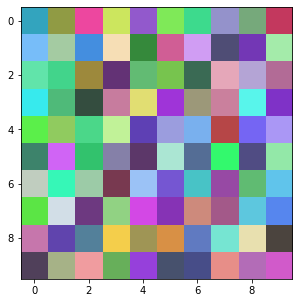

In [230]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
%matplotlib inline

#creation of the initial image
operator_dim = 2
image_dim = operator_dim*5
min_color = 50
max_color = 250
random_colored_image = np.array(min_color + (max_color-min_color)*np.random.random((image_dim,image_dim,3)),dtype = 'uint8')


R = random_colored_image[:,:,0] 
G = random_colored_image[:,:,1] 
B = random_colored_image[:,:,2] 


print_colors = False
if print_colors:
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(R,'Reds')
    plt.subplot(1,3,2)
    plt.imshow(G,'Greens')
    plt.subplot(1,3,3)
    plt.imshow(B,'Blues')
    plt.show()



plt.figure(figsize=(5,5))
plt.imshow(random_colored_image)
plt.show()





# save and import if needed
# cv2.imwrite('king_position_weight.jpg', image)
# gray = cv2.imread("king_position_weight.jpg", cv2.IMREAD_GRAYSCALE)

In [216]:
#function to optimize

#the variation of color between neighbours

#division of the image in the 3 colors
def fitness(image):

    R = image[:,:,0] 
    G = image[:,:,1] 
    B = image[:,:,2] 
    
    #kernels 
    kernels = []
#forward mean
#     kernels.append(np.array([[-1,1],
#                        [-2,2],
#                        [-1,1]])/4)
#     kernels.append(np.array([[-1,-2,-1],
#                        [1,2,1]])/4)
#central mean
#     kernels.append(np.array([[-1,0,1],
#                        [-2,0,2],
#                        [-1,0,1]])/4)
#     kernels.append(np.array([[-1,-2,-1],
#                        [0,0,0],
#                        [1,2,1]])/4)
#forward
    kernels.append(np.array([[-1,1]]))
    kernels.append(np.array([[-1],
                             [1]]))
    
    def slider(operator):
        i = 0
        value = 0
        i_operator,j_operator = operator.shape
        for i in range(image_dim-i_operator+1):
            for j in range(image_dim-j_operator+1):
                tmp_part_of_image = R[i:i+i_operator,j:j+j_operator]
                tmp_result = abs(np.sum(tmp_part_of_image*operator))
                value += tmp_result
                tmp_part_of_image = G[i:i+i_operator,j:j+j_operator]
                tmp_result = abs(np.sum(tmp_part_of_image*operator))
                value += tmp_result
                tmp_part_of_image = B[i:i+i_operator,j:j+j_operator]
                tmp_result = abs(np.sum(tmp_part_of_image*operator))
                value += tmp_result
                j+=1
            i+=1
        return value
    fitness_value = 0
    for kernel in kernels:
        fitness_value += slider(kernel)
    return fitness_value

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


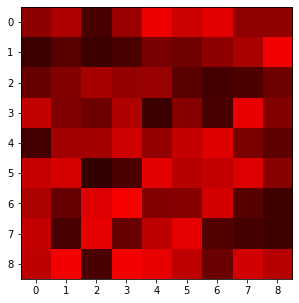

1551.0


In [65]:
#search for the best image with permutation(base)
max_iterations = 10000
good_value = 10
i = 0
best = fitness(random_colored_image)
while(best>=good_value and i < max_iterations):
    permutation = image_permutation()
    candidate = fitness(permutation)
    if candidate < best:
        best = candidate
        best_image = permutation
    i+=1
    if not i%(max_iterations/10):
        print(max_iterations/i)
    
    
plt.figure(figsize=(5,5))
plt.imshow(best_image)
plt.show()

print(best)



In [119]:
#creation of neighbourhood

#permutation
def image_permutation():
    return np.random.permutation(permutation)

#k-exchange
def k_exchange(k,image):
    for i in range(k):
        coordinates_to_exchange = np.array(image_dim*np.random.random((2,2)),dtype = int)
        a = copy.copy(image[coordinates_to_exchange[0,:][0],coordinates_to_exchange[0,:][1]])
        image[coordinates_to_exchange[0,:][0],coordinates_to_exchange[0,:][1]] = image[coordinates_to_exchange[1,:][0],coordinates_to_exchange[1,:][1]] 
        image[coordinates_to_exchange[1,:][0],coordinates_to_exchange[1,:][1]] = a
        
        


In [231]:
#hill climbing
def hill_climbing(max_iterations,good_value,neighbour_dimension,k,image):
    #video generation
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    # N.B. we need to specify the correct width and height of the frames otherwise we will not be able to reproduce the video
    out = cv2.VideoWriter('output.avi', fourcc, 20, (image_dim,image_dim))
    i = 0
    stop = False
    best = fitness(image)
    best_image = image
    while(best>=good_value and i < max_iterations and not stop):
        for j in range(neighbour_dimension):
            stop = True
            image = np.copy(best_image)
            k_exchange(k,image)
            candidate = fitness(image)
            i+=1
            if not i%(max_iterations/10):
                print(max_iterations/10/i)
            if candidate < best:
                best = candidate
                best_image = np.copy(image)
                out.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                stop = False
                break 
        
    out.release()
    if best < good_value:
        print('better than good value')
    elif i>max_iterations:
        print('max iteration')
    else:
        print('local minimum')
    print('')
    print(best)       

    plt.figure(figsize=(5,5))
    plt.imshow(best_image)
    plt.show()
    return best_image

    

1.0
0.5
0.3333333333333333
0.25
0.2
0.16666666666666666
0.14285714285714285
0.125
0.1111111111111111
0.1
0.09090909090909091
max iteration

16362


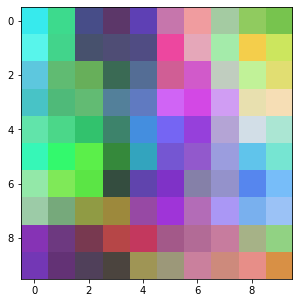

In [232]:
max_iterations = 10000
good_value = 100
best_image = hill_climbing(max_iterations,good_value,2000,1,random_colored_image)



In [233]:
play_video('output.avi')

Released Video Resource


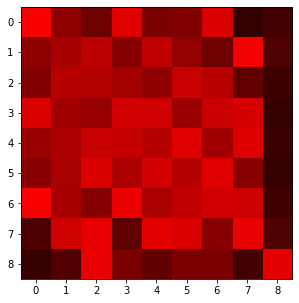

In [162]:
plt.figure(figsize=(5,5))
plt.imshow(best_image)
plt.show()

local minimum

498.5


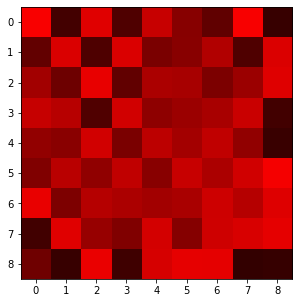

In [154]:
#recursive hill climb
best_image = hill_climbing(max_iterations,good_value,3000,1,best_image)

In [229]:
# Put the code in try-except statements catch the keyboard exception and release the camera device and 
# continue with the rest of code.

from IPython.display import clear_output
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    # Try-except statement to manage exceptions
    try:
        while(True):
            # Capture frame
            ret, frame = cap.read()
            if not ret or frame is None:
                # Release the Video if ret is false
                cap.release()
                print("Released Video Resource")
                # Break exit the for loops
                break
            
            # Display the frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.axis('off')
            plt.title("Input Stream")
            plt.imshow(frame)
            plt.show()
            
            # Clear cell output when new frame is available
            clear_output(wait=True)
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        cap.release()
        print("Released Video Resource")